<a href="https://colab.research.google.com/github/Hami4214/Advanced-Research-in-data-science-/blob/main/ARMA_and_LSTM_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# **AMZN DATASET**




# **Load and Inspect the Data**


In [2]:
# Load the dataset
amzn_data = pd.read_csv('/content/AMZN.csv', parse_dates=True, index_col='Date')

# Check the first few rows of the data
amzn_data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


# **Make Initial Plots of the Data**



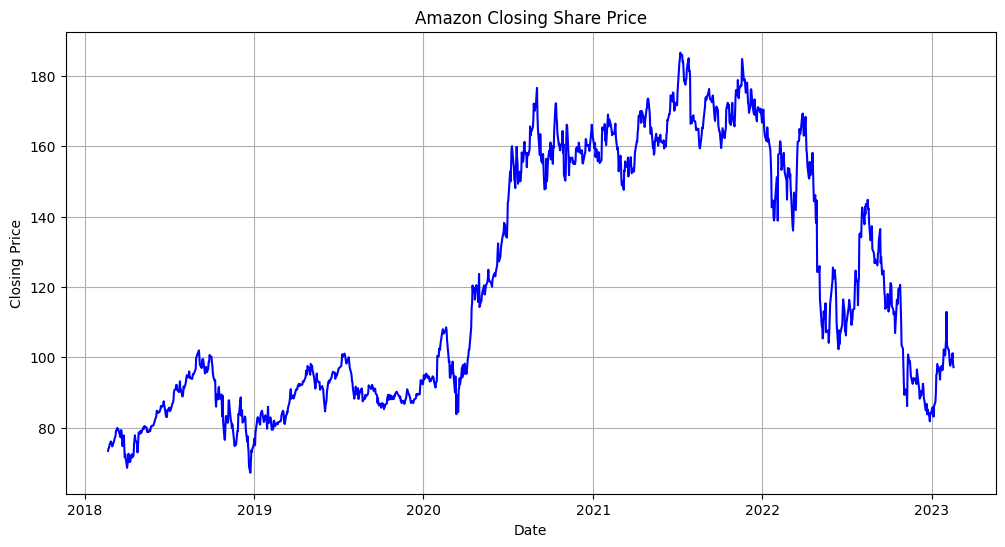

In [3]:
# Plotting the Amazon closing share price data
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close'], color='blue', label='Closing Price')
plt.title('Amazon Closing Share Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# **Perform All the Time Series Analysis Tasks to Test for Non-Stationarity**


In [4]:
# Function to perform ADF Test
def test_stationarity(series):
    """
    ADF test to check stationarity.
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] < 0.05:
        print("The series is likely stationary (Reject null hypothesis).")
    else:
        print("The series is likely non-stationary (Fail to reject null hypothesis).")

# Applying ADF test to Amzn closing prices
test_stationarity(amzn_data['Close'])


ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Critical Values: {'1%': np.float64(-3.4355588184378574), '5%': np.float64(-2.8638402312881497), '10%': np.float64(-2.5679946684494275)}
The series is likely non-stationary (Fail to reject null hypothesis).


## **Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)**




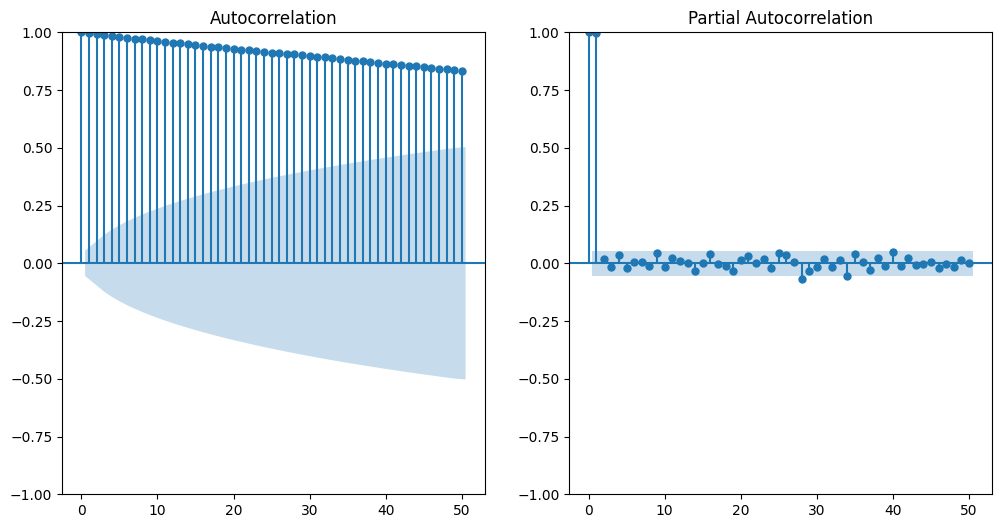

In [5]:
# Autocorrelation and Partial Autocorrelation Plotting
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(amzn_data['Close'], ax=plt.gca(), lags=50)
plt.subplot(122)
plot_pacf(amzn_data['Close'], ax=plt.gca(), lags=50)
plt.show()


## **Time Series Decomposition: Understanding Trend and Seasonality**



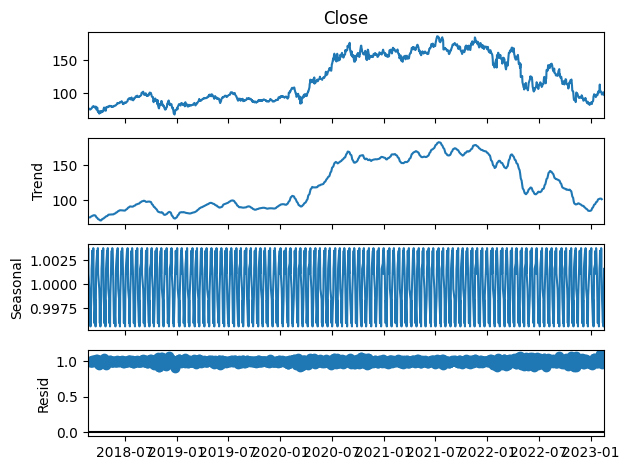

In [6]:

decomp = seasonal_decompose(amzn_data['Close'], model='multiplicative', period=12)
decomp.plot()
plt.show()


# **Make the Data Stationary**



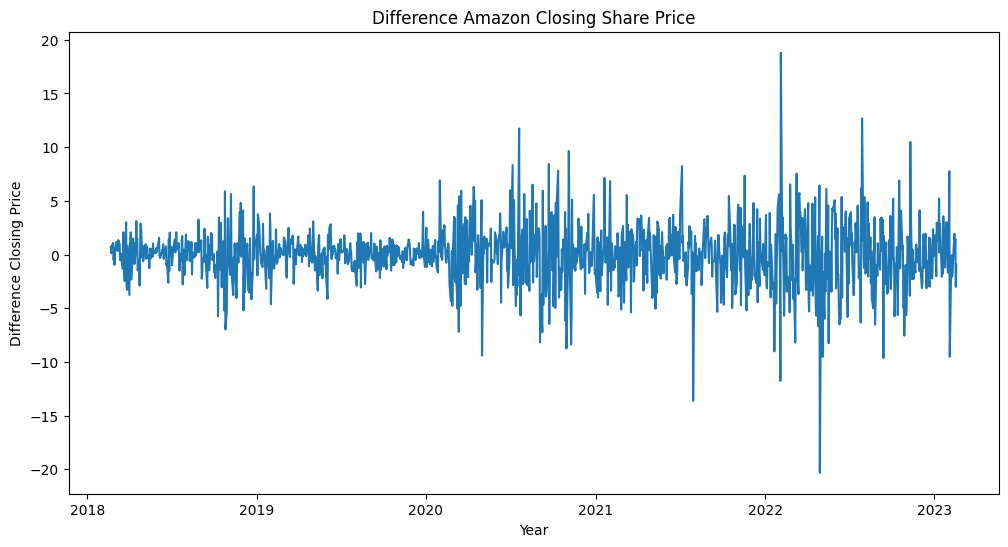

ADF Statistic: -36.25077933242776
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4355629707955395), '5%': np.float64(-2.863842063387667), '10%': np.float64(-2.567995644141416)}
The series is likely stationary (Reject null hypothesis).


In [8]:
# Differencing the series to remove trend and make it stationary
amzn_data['Close_diff'] = amzn_data['Close'].diff().dropna()
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close_diff'])
plt.title('Difference Amazon Closing Share Price')
plt.xlabel('Year')
plt.ylabel('Difference Closing Price')
plt.show()

# Re-test stationarity after differencing
test_stationarity(amzn_data['Close_diff'].dropna())  # Re-apply the ADF test to the differenced data


# **Find the Best Model Parameters: p, d, q**

Optimize p, d, q by comparing AIC values or using grid search

In [10]:
# Grid Search for Optimal p, d, q values
best_aic = np.inf
best_order = None
d=0

for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = ARIMA(amzn_data['Close'], order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue

print(f"Best ARMA Model Parameters: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARMA Model Parameters: p=3, d=0, q=2


## Define and Fit ARMA Model ##




In [12]:
# Define ARMA model parameters (p, d, q)
p, d, q = 2, 2, 3
arma_model = ARIMA(amzn_data['Close'], order=(p, d, q))
arma_model_fit = arma_model.fit()

# Print ARMA model summary
print(arma_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -3057.762
Date:                Tue, 17 Jun 2025   AIC                           6127.524
Time:                        21:28:51   BIC                           6158.343
Sample:                             0   HQIC                          6139.107
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6945      0.015   -111.999      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.671      0.000      -0.989      -0.931
ma.L1          0.6973      0.043     16.083      0.0

# **Test Model Performance**





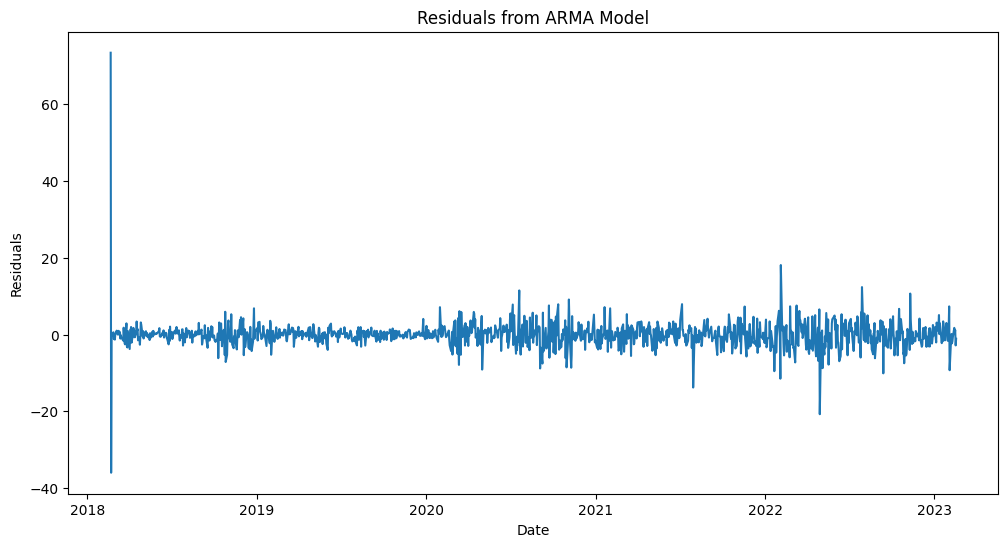

      lb_stat     lb_pvalue
1   36.604013  1.447335e-09
2   36.604156  1.125923e-08
3   36.788467  5.100814e-08
4   36.886764  1.900697e-07
5   36.910288  6.242686e-07
6   36.961630  1.791476e-06
7   36.972300  4.747671e-06
8   37.586590  8.974345e-06
9   37.631093  2.029781e-05
10  37.632442  4.396847e-05


In [14]:
residuals = arma_model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from ARMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Perform Ljung-Box test on residuals to check for autocorrelation
ljung_box_result = acorr_ljungbox(residuals, lags=10)
print(ljung_box_result)

# **Forecast the Next 24 Months into the future with ARMA**



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
<ipython-input-17-148773744>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]


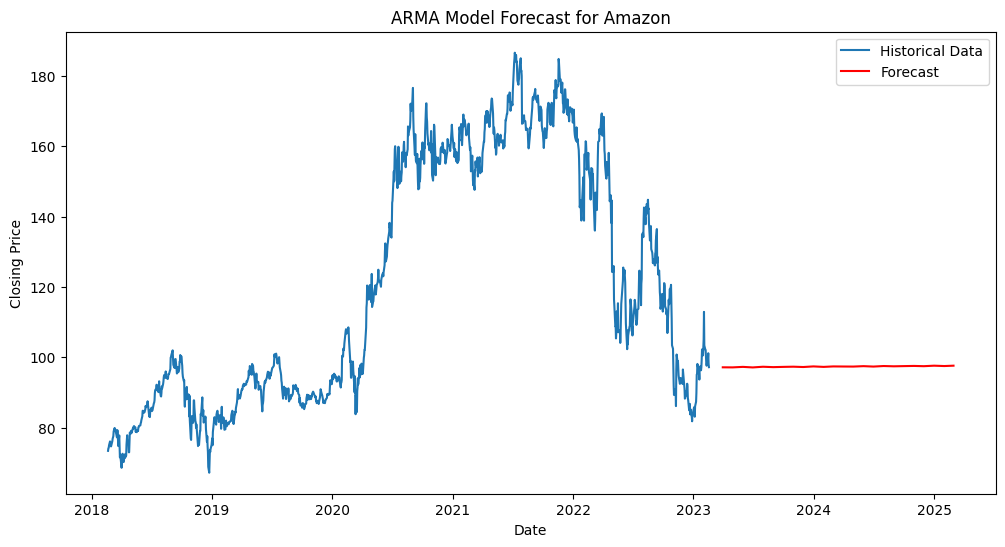

In [17]:
# Forecast the next 24 months using the ARMA model
forecast_steps = 24
forecast = arma_model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close'], label='Historical Data')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('ARMA Model Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


# **Build an RNN-Based Model (LSTM)**





/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0084
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


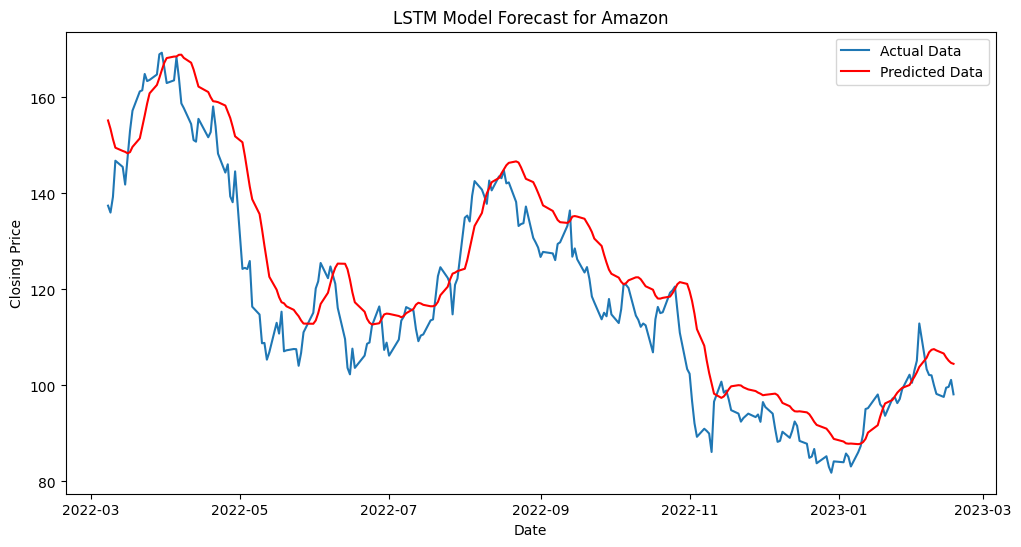

In [20]:
# Normalize the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
amzn_scaled = scaler.fit_transform(amzn_data['Close'].values.reshape(-1, 1))

# Prepare dataset
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(amzn_scaled, time_step)


X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Predict using LSTM model
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform([Y_test])

# Plot LSTM predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(amzn_data.index[-len(Y_test_rescaled[0]):], Y_test_rescaled[0], label='Actual Data')
plt.plot(amzn_data.index[-len(predictions):], predictions, label='Predicted Data', color='red')
plt.title('LSTM Model Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# **Forecast 24 Months with LSTM**





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


<ipython-input-22-2742338081>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]


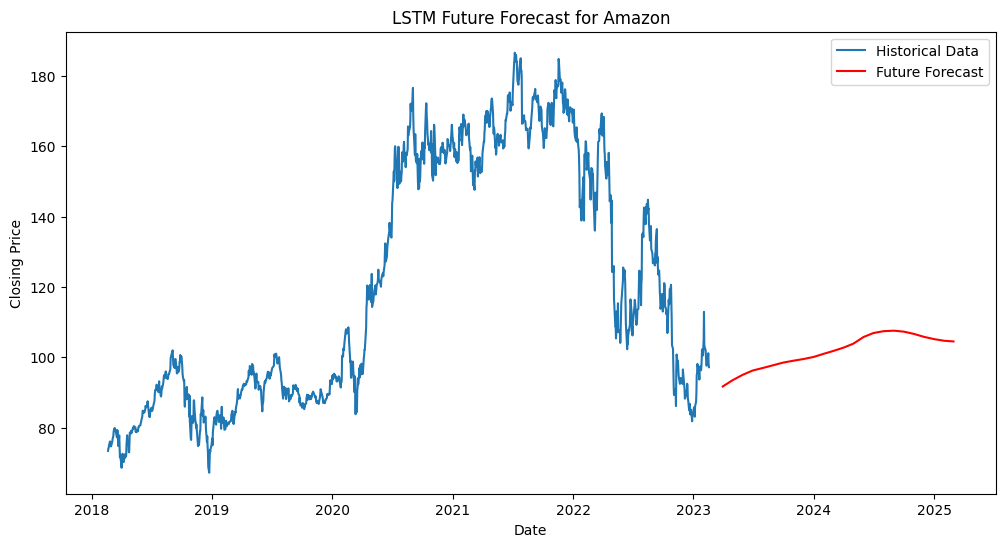

In [22]:
# Predict 24 months ahead using LSTM
forecast_steps = 24
future_predictions = model.predict(X_test[-forecast_steps:])

# Inverse scale the forecast
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Plot the forecast
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]

plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close'], label='Historical Data')
plt.plot(forecast_index, future_predictions_rescaled, label='Future Forecast', color='red')
plt.title('LSTM Future Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Build an RNN-Based Model (GRU)##

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.0127
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


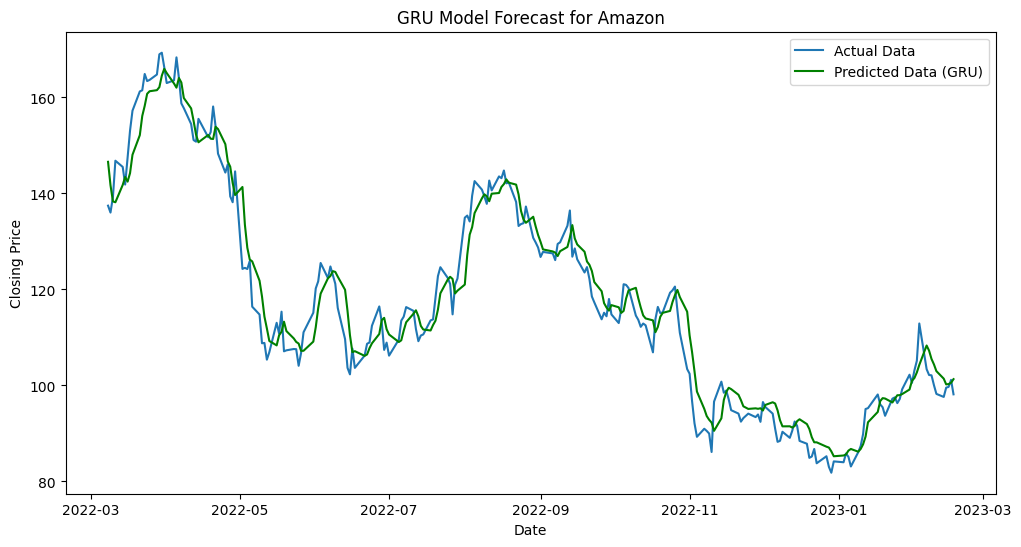

In [23]:

# Normalize the data for GRU model
scaler = MinMaxScaler(feature_range=(0, 1))
amzn_scaled = scaler.fit_transform(amzn_data['Close'].values.reshape(-1, 1))

# Prepare dataset function
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create training and testing data
time_step = 60
X, Y = create_dataset(amzn_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile and train the GRU model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Predict using GRU model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform([Y_test])

# Plot GRU predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(amzn_data.index[-len(Y_test_rescaled[0]):], Y_test_rescaled[0], label='Actual Data')
plt.plot(amzn_data.index[-len(predictions):], predictions, label='Predicted Data (GRU)', color='green')
plt.title('GRU Model Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


## Forecast 24 Months with GRU ##

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


<ipython-input-24-1830632969>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]


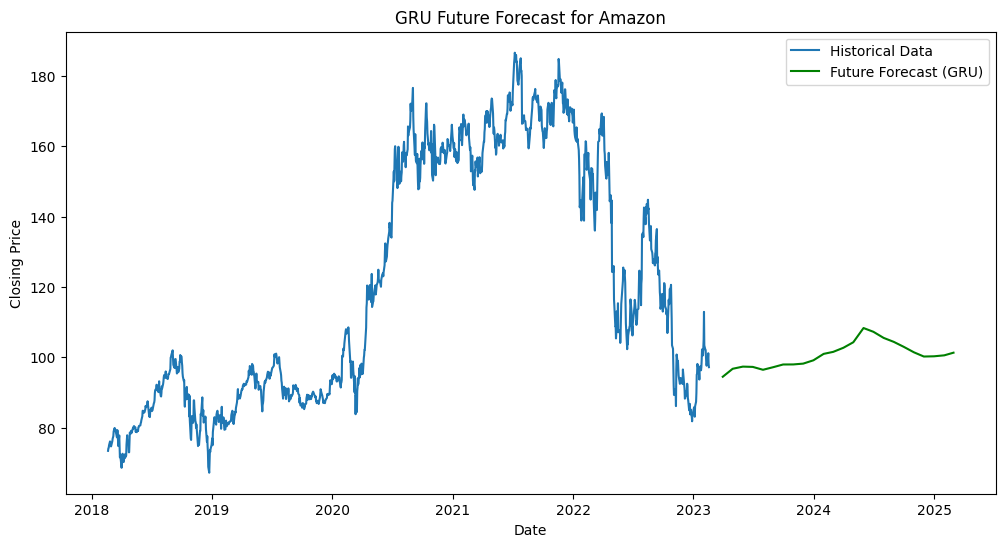

In [24]:
# Forecast 24 months using GRU
forecast_steps = 24
future_predictions = model.predict(X_test[-forecast_steps:])

# Inverse scale the forecast
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Build forecast date index
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close'], label='Historical Data')
plt.plot(forecast_index, future_predictions_rescaled, label='Future Forecast (GRU)', color='green')
plt.title('GRU Future Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


# **Compute Evaluation Metrics**


In [26]:
# Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_rescaled[0], predictions)
print(f'Mean Squared Error (MSE) of the LSTM model: {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) of the LSTM model: {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test_rescaled[0], predictions)
print(f'Mean Absolute Error (MAE) of the LSTM model: {mae}')

# R-squared (R²)
r2 = r2_score(Y_test_rescaled[0], predictions)
print(f'R-squared (R²) of the LSTM model: {r2}')

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test_rescaled[0] - predictions) / Y_test_rescaled[0])) * 100
print(f'Mean Absolute Percentage Error (MAPE) of the LSTM model: {mape}%')

# Symmetric Mean Absolute Percentage Error (sMAPE)
smape = np.mean(2 * np.abs(predictions - Y_test_rescaled[0]) / (np.abs(Y_test_rescaled[0]) + np.abs(predictions))) * 100
print(f'Symmetric Mean Absolute Percentage Error (sMAPE) of the LSTM model: {smape}%')

Mean Squared Error (MSE) of the LSTM model: 21.41736854607837
Root Mean Squared Error (RMSE) of the LSTM model: 4.627890291059023
Mean Absolute Error (MAE) of the LSTM model: 3.6667247210205067
R-squared (R²) of the LSTM model: 0.9555116081839358
Mean Absolute Percentage Error (MAPE) of the LSTM model: 21.043619968062423%
Symmetric Mean Absolute Percentage Error (sMAPE) of the LSTM model: 20.271101015778722%


# **Actual vs. Predicted Values (ARMA vs. LSTM)**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


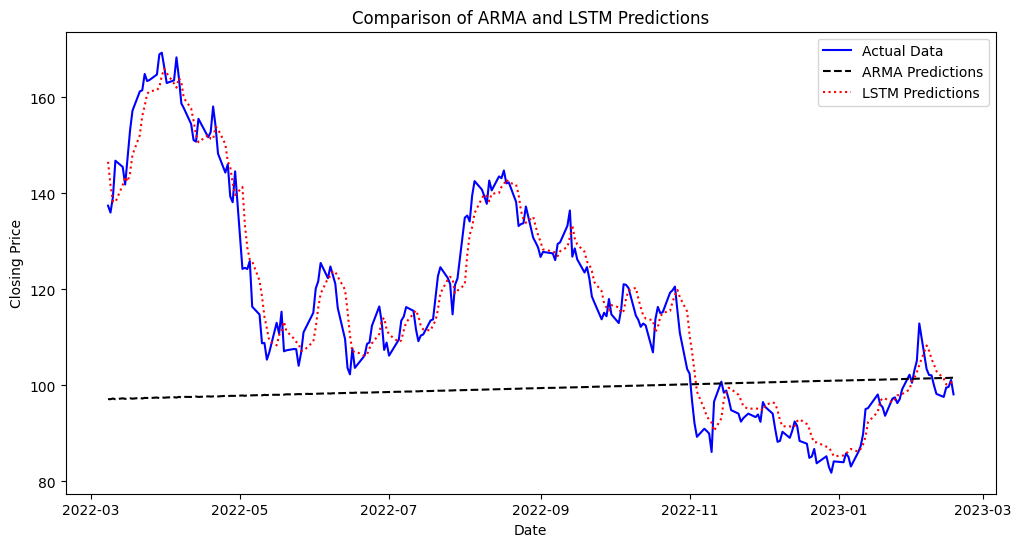

In [27]:
# ARMA model predictions
arma_predictions = arma_model_fit.forecast(steps=len(Y_test_rescaled[0]))

# LSTM model predictions (already computed)
lstm_predictions = predictions


plt.figure(figsize=(12, 6))
plt.plot(amzn_data.index[-len(Y_test_rescaled[0]):], Y_test_rescaled[0], label='Actual Data', color='blue')
plt.plot(amzn_data.index[-len(arma_predictions):], arma_predictions, label='ARMA Predictions', color='black', linestyle='--')
plt.plot(amzn_data.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Predictions', color='red', linestyle=':')

plt.title('Comparison of ARMA and LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


# **Plot Residuals (Differences Between Actual and Predicted Values)**





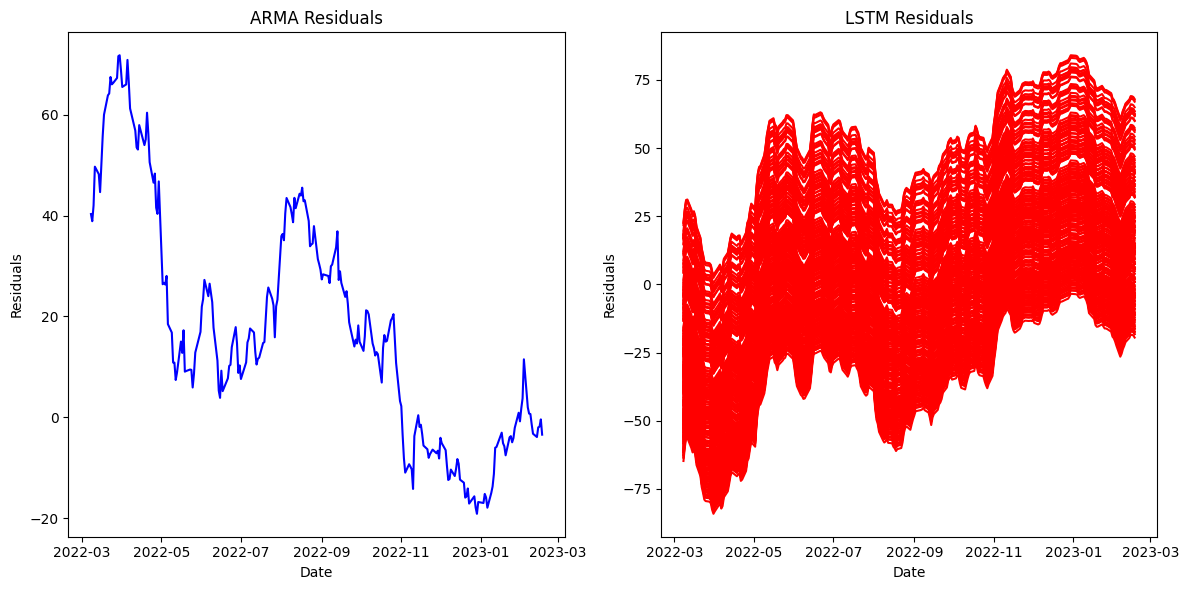

In [28]:
# ARMA residuals
arma_residuals = Y_test_rescaled[0] - arma_predictions

# LSTM residuals
lstm_residuals = Y_test_rescaled[0] - lstm_predictions

# Plot the residuals for ARMA and LSTM
plt.figure(figsize=(12, 6))

# Plot ARMA residuals
plt.subplot(121)
plt.plot(amzn_data.index[-len(arma_residuals):], arma_residuals, label='ARMA Residuals', color='blue')
plt.title('ARMA Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot LSTM residuals
plt.subplot(122)
plt.plot(amzn_data.index[-len(lstm_residuals):], lstm_residuals, label='LSTM Residuals', color='red')
plt.title('LSTM Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


# **Plot the Forecast Horizons of Both Models**




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-29-3954513348>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=25, freq='M')[1:]


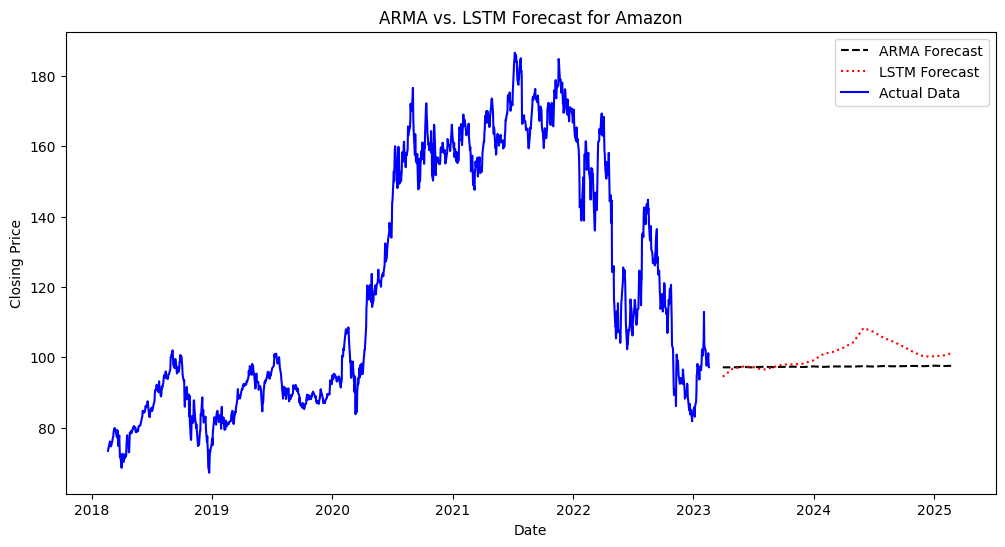

In [29]:
# ARMA forecast for the next 24 months (already computed)
arma_forecast = arma_model_fit.forecast(steps=24)

# LSTM forecast for the next 24 months
lstm_forecast = future_predictions_rescaled  # The LSTM forecast for the next 24 months (inverse scaled)

# Generate future time index
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=25, freq='M')[1:]

# Plot the forecasts of both models
plt.figure(figsize=(12, 6))

# Plot ARMA forecast
plt.plot(forecast_index, arma_forecast, label='ARMA Forecast', color='black', linestyle='--')

# Plot LSTM forecast
plt.plot(forecast_index, lstm_forecast, label='LSTM Forecast', color='red', linestyle=':')

# Plot the actual historical data for context
plt.plot(amzn_data.index, amzn_data['Close'], label='Actual Data', color='blue')

plt.title('ARMA vs. LSTM Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


## **Compare Metrics for ARMA and LSTM**


In [30]:
# Mean Squared Error (MSE) for both models
arma_mse = mean_squared_error(Y_test_rescaled[0], arma_predictions)
lstm_mse = mean_squared_error(Y_test_rescaled[0], lstm_predictions)

# Mean Absolute Error (MAE) for both models
arma_mae = mean_absolute_error(Y_test_rescaled[0], arma_predictions)
lstm_mae = mean_absolute_error(Y_test_rescaled[0], lstm_predictions)

# Root Mean Squared Error (RMSE) for both models
arma_rmse = np.sqrt(arma_mse)
lstm_rmse = np.sqrt(lstm_mse)

# R-squared (R²) for both models
arma_r2 = r2_score(Y_test_rescaled[0], arma_predictions)
lstm_r2 = r2_score(Y_test_rescaled[0], lstm_predictions)

print(f"ARMA Model Evaluation Metrics:")
print(f"MSE: {arma_mse}, MAE: {arma_mae}, RMSE: {arma_rmse}, R²: {arma_r2}")
print("\n")
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {lstm_mse}, MAE: {lstm_mae}, RMSE: {lstm_rmse}, R²: {lstm_r2}")


ARMA Model Evaluation Metrics:
MSE: 843.2843476097148, MAE: 22.528421312861052, RMSE: 29.039358595012303, R²: -0.751679455302855


LSTM Model Evaluation Metrics:
MSE: 21.41736854607837, MAE: 3.6667247210205067, RMSE: 4.627890291059023, R²: 0.9555116081839358




# **Johnson & Johnson (jj.csv) dataset**



# **Load and Inspect the Dataset**



In [31]:

# Load the dataset
data = pd.read_csv('/content/jj.csv', parse_dates=['date'], dayfirst=True)

# Display the first few rows to check the data
data.head()

# Rename columns to be more descriptive
data.rename(columns={'date': 'date', 'data': 'sales_value'}, inplace=True)

# Display the updated dataset
data.head()



,date,sales_value
0,1960-01-01,0.71
1,1960-01-04,0.63
2,1960-02-07,0.85
3,1960-01-10,0.44
4,1961-01-01,0.61


# ** Plot the initial data to understand its structure**



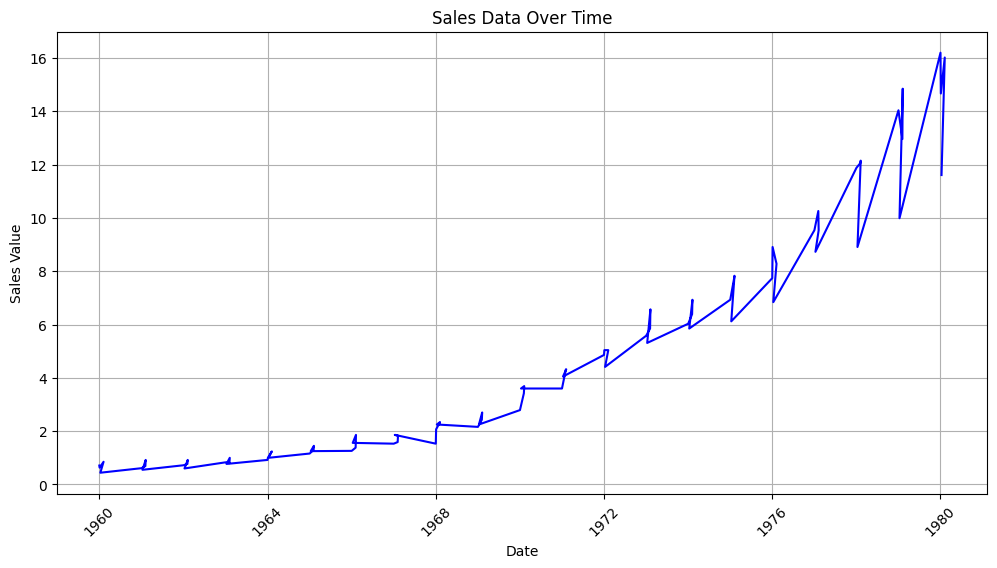

In [36]:
# Plotting the sales data over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['sales_value'],color='blue')
plt.title('Sales Data Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# **Stationarity Test**

In [37]:



def test_stationarity(series):
    """
    Perform Augmented Dickey-Fuller test to check if the series is stationary.
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] < 0.05:
        print("The series is likely stationary (Reject null hypothesis).")
    else:
        print("The series is likely non-stationary (Fail to reject null hypothesis).")

# Perform the ADF test on the sales_value data
test_stationarity(data['sales_value'])


ADF Statistic: 2.7420165734574744
p-value: 1.0
Critical Values: {'1%': np.float64(-3.524624466842421), '5%': np.float64(-2.9026070739026064), '10%': np.float64(-2.5886785262345677)}
The series is likely non-stationary (Fail to reject null hypothesis).


## **ACF and PACF Plots**

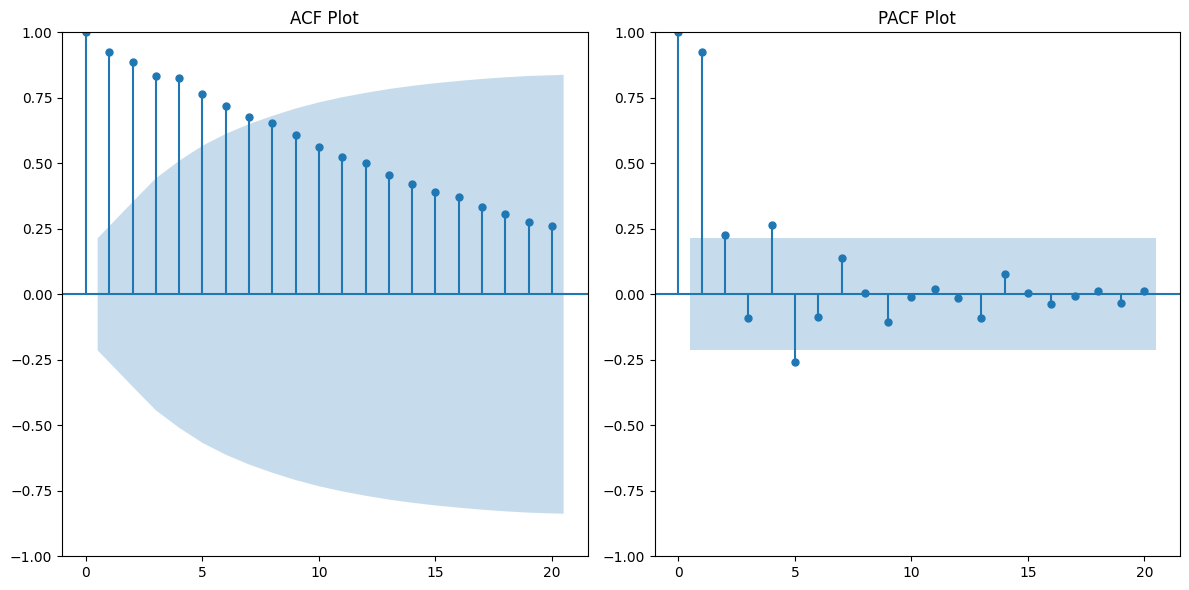

In [43]:

# Plotting the ACF and PACF for the 'sales_value' data
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(data['sales_value'], ax=plt.gca(), lags=20)
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(data['sales_value'], ax=plt.gca(), lags=20)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()


## **Making the Data Stationary (if needed)**




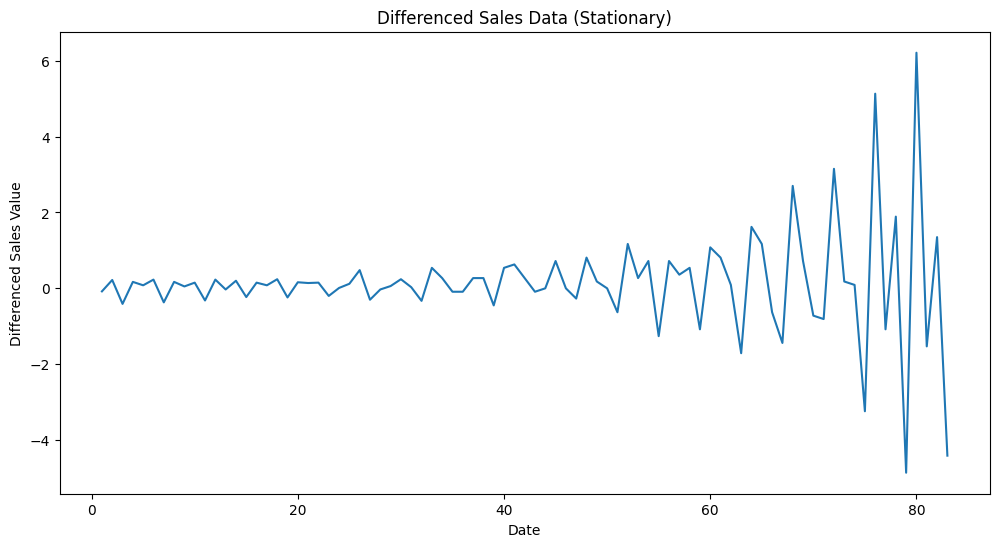

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305
Critical Values: {'1%': np.float64(-3.524624466842421), '5%': np.float64(-2.9026070739026064), '10%': np.float64(-2.5886785262345677)}
The series is likely non-stationary (Fail to reject null hypothesis).
ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682
Critical Values: {'1%': np.float64(-3.524624466842421), '5%': np.float64(-2.9026070739026064), '10%': np.float64(-2.5886785262345677)}
The series is likely stationary (Reject null hypothesis).


In [44]:
# Differencing the series to make it stationary
data['sales_value_diff'] = data['sales_value'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['sales_value_diff'])
plt.title('Differenced Sales Data (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales Value')
plt.show()

# Re-run the ADF test on the differenced series
test_stationarity(data['sales_value_diff'].dropna())
data['sales_value_diff2'] = data['sales_value_diff'].diff().dropna()
test_stationarity(data['sales_value_diff2'].dropna())



## **PDQ**

In [45]:
# Assume data['sales_value_diff'].dropna() is the stationary version
best_aic = np.inf
best_order = None


# Grid search over p and q (both from 1 to 5)
for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = ARIMA(data['sales_value'], order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue

print(f"Best ARMA/ARIMA Model Parameters for JJ dataset: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}")



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/s

Best ARMA/ARIMA Model Parameters for JJ dataset: p=5, d=1, q=3


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# ** Define and Fit an ARMA Model**


We define and fit the ARMA model (ARIMA with p=2, d=1, q=2).



In [46]:

# Fit the ARMA model (ARIMA model with d=0 for stationary data)
p, d, q = 5, 1, 3
arma_model = ARIMA(data['sales_value'], order=(p, d, q))
arma_model_fit = arma_model.fit()

# Print the ARMA model summary
print(arma_model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            sales_value   No. Observations:                   84
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 -49.268
Date:                Tue, 17 Jun 2025   AIC                            116.536
Time:                        23:08:41   BIC                            138.306
Sample:                             0   HQIC                           125.282
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7951      0.326     -2.436      0.015      -1.435      -0.155
ar.L2         -0.0302      0.054     -0.555      0.579      -0.137       0.076
ar.L3          0.0443      0.048      0.919      0.3

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **Step 4: Evaluate the ARMA Model**


We evaluate the residuals of the ARMA model using the Ljung-Box test and plot them.


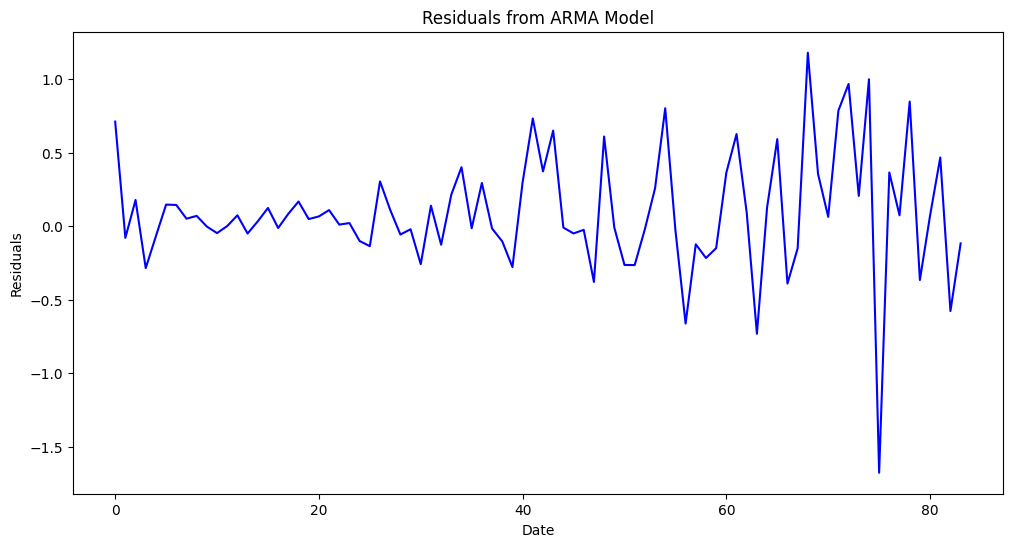

     lb_stat  lb_pvalue
1   0.519193   0.471186
2   0.954793   0.620396
3   1.730880   0.630090
4   1.745137   0.782503
5   2.343576   0.799846
6   2.438811   0.875252
7   4.401575   0.732535
8   4.407843   0.818581
9   4.519098   0.874057
10  5.082107   0.885626


In [48]:
# Plot the residuals of the ARMA model
residuals = arma_model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, color="blue")
plt.title('Residuals from ARMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Perform Ljung-Box test on residuals to check for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(residuals, lags=10)
print(ljung_box_result)


# **Forecast the Next 24 Months**





<ipython-input-51-1219750064>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]


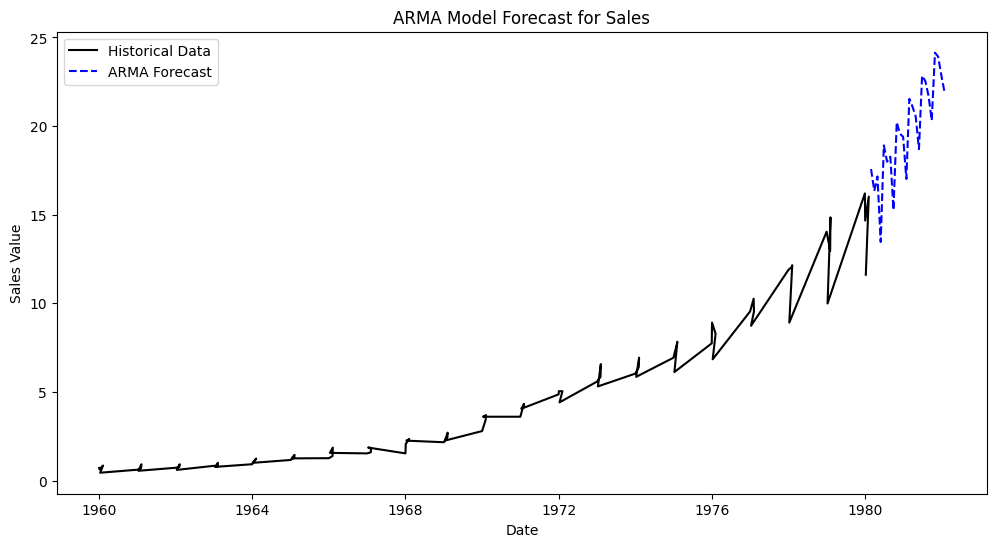

In [51]:
# Forecast the next 24 months
forecast_steps = 24
forecast = arma_model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]

# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['sales_value'], label='Historical Data', color='black')
plt.plot(forecast_index, forecast, label='ARMA Forecast', color='blue', linestyle='--')
plt.title('ARMA Model Forecast for Sales')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.show()


# **Step 6: Evaluate the Model's Performance**

In [52]:
# Define actual and predicted values
actual = data['sales_value'][-len(forecast):].values
predicted = forecast

# Compute the basic metrics
arma_mse = mean_squared_error(actual, predicted)
arma_rmse = np.sqrt(arma_mse)
arma_mae = mean_absolute_error(actual, predicted)
arma_r2 = r2_score(actual, predicted)


epsilon = 1e-10  # small constant to avoid division by zero

# Compute MAPE and sMAPE safely
arma_mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100
arma_smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + epsilon)) * 100

# Print results
print("ARMA Model Evaluation Metrics:")
print(f"MSE: {arma_mse:.4f}")
print(f"RMSE: {arma_rmse:.4f}")
print(f"MAE: {arma_mae:.4f}")
print(f"R²: {arma_r2:.4f}")
print(f"MAPE: {arma_mape:.2f}%")
print(f"sMAPE: {arma_smape:.2f}%")


ARMA Model Evaluation Metrics:
MSE: 84.8746
RMSE: 9.2127
MAE: 9.1420
R²: -8.7473
MAPE: 94.12%
sMAPE: 62.63%


# **GRU Model for Time Series Forecasting**

## ** Data Preparation for GRU Model**


In [53]:
# Scale the JJ sales data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['sales_value'].values.reshape(-1, 1))

# Create sequences of past 'time_step' values
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

#  Set lookback window and create input/output
time_step = 60
X, Y = create_dataset(data_scaled, time_step)

#  Reshape for GRU input format: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


#  Split into training and testing sets (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


##**Build the GRU Model**


In [54]:
#Build improved GRU model
gru_model = Sequential()
gru_model.add(GRU(units=100, return_sequences=True, input_shape=(time_step, 1)))
gru_model.add(Dropout(0.2))  # regularization
gru_model.add(GRU(units=100, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=25, activation='relu'))
gru_model.add(Dense(units=1))  # output layer

# Compile and train
gru_model.compile(optimizer='adam', loss='mean_squared_error')
history = gru_model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_test, Y_test), verbose=1)


#  Predict and inverse transform to original scale
predictions_scaled = gru_model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)
Y_test_rescaled = scaler.inverse_transform(Y_test)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.2988 - val_loss: 0.4381
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.2209 - val_loss: 0.2871
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.1368 - val_loss: 0.1578
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0836 - val_loss: 0.0649
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0309 - val_loss: 0.0269
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0127 - val_loss: 0.0550
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0356 - val_loss: 0.0991
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0572 - val_loss: 0.1041
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0411 - val_loss: 0.0822
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0384 - val_loss: 0.0532
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0214 - val_loss: 0.0335
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.0135 - val_loss: 0.0272
Epo

## **Evaluate the GRU Model**


In [55]:
# Evaluate model performance
mse = mean_squared_error(Y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_rescaled, predictions)
r2 = r2_score(Y_test_rescaled, predictions)

epsilon = 1e-10
mape = np.mean(np.abs((Y_test_rescaled - predictions) / (Y_test_rescaled + epsilon))) * 100
smape = np.mean(2 * np.abs(Y_test_rescaled - predictions) / (np.abs(Y_test_rescaled) + np.abs(predictions) + epsilon)) * 100

print("Improved GRU Model Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")


Improved GRU Model Evaluation Metrics:
MSE: 6.9013
RMSE: 2.6270
MAE: 2.4597
R²: -0.1238
MAPE: 19.42%
sMAPE: 18.39%


## **Visualize GRU Model Predictions**


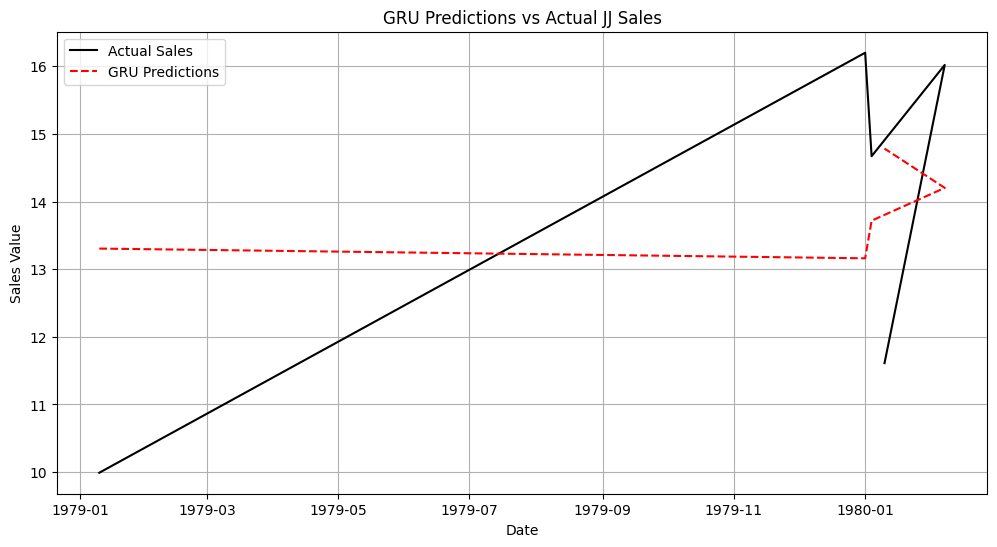

In [56]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['date'][-len(predictions):], scaler.inverse_transform(data_scaled)[-len(predictions):], label='Actual Sales', color='black')
plt.plot(data['date'][-len(predictions):], predictions, label='GRU Predictions', color='red', linestyle='--')
plt.title('GRU Predictions vs Actual JJ Sales')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.show()


# **Forecast Next 24 Months Using GRU**


In [57]:
# Forecast next 24 months using the trained GRU model
forecast_steps = 24
last_sequence = data_scaled[-time_step:].reshape(1, time_step, 1)
future_predictions_scaled = []

for _ in range(forecast_steps):
    next_pred = gru_model.predict(last_sequence)[0][0]
    future_predictions_scaled.append(next_pred)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


# **Create Dates & Plot Forecast**

<ipython-input-58-1815465779>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


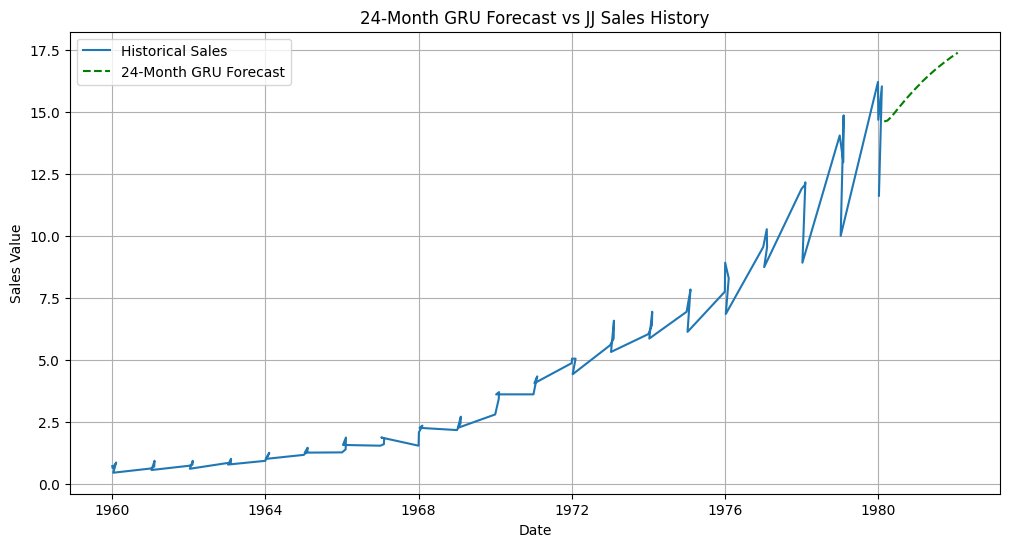

In [58]:
# Generate future dates
last_date = data['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

#Plot historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['sales_value'], label='Historical Sales')
plt.plot(future_dates, future_predictions, label='24-Month GRU Forecast', color='green', linestyle='--')
plt.title('24-Month GRU Forecast vs JJ Sales History')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.show()


## **Compare GRU with ARMA and GRU Models**





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


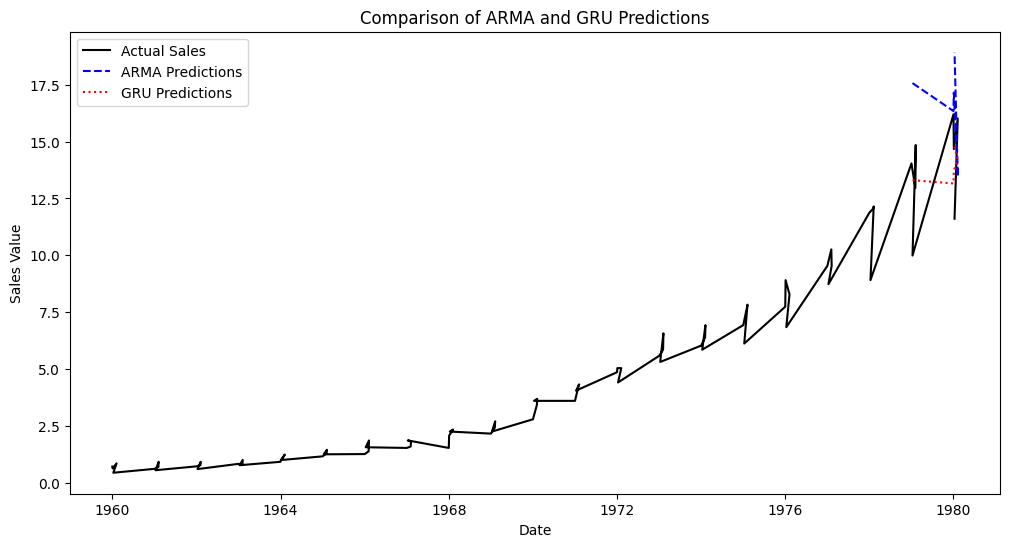

In [59]:
# Plot the actual values, ARMA predictions, and GRU predictions
plt.figure(figsize=(12, 6))

gru_predictions = gru_model.predict(X_test)
gru_predictions_rescaled = scaler.inverse_transform(gru_predictions)
# Plot actual values
plt.plot(data['date'], data['sales_value'], label='Actual Sales', color='black')

# Plot ARMA model predictions (use the forecast from ARMA)
arma_forecast = arma_model_fit.forecast(steps=len(Y_test))
plt.plot(data['date'][-len(Y_test):], arma_forecast, label='ARMA Predictions', color='blue', linestyle='--')


# Plot GRU model predictions
plt.plot(data['date'][-len(gru_predictions_rescaled):], gru_predictions_rescaled, label='GRU Predictions', color='red', linestyle=':')

plt.title('Comparison of ARMA and GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.show()
